Loading data from: C:\Users\nithi\Desktop\NITHISH\2020.06.19.csv
Successfully loaded dataset with 765360 rows and 16 columns

First 5 rows of the dataset:
     avg_ipt  bytes_in  bytes_out  dest_ip  dest_port   entropy  num_pkts_out  \
0   7.500000       342       3679      786     9200.0  5.436687             2   
1   0.000000         0          0      786    55972.0  0.000000             1   
2   0.500000     15440        942      786     9300.0  2.203135             3   
3  20.217391       622      31010      786     9300.0  1.189945            23   
4   0.000000         0          0      786    59498.0  0.000000             1   

   num_pkts_in  proto  src_ip  src_port          time_end        time_start  \
0            2      6     786   57392.0  1592533725648144  1592533725632946   
1            1      6   49453   49493.0  1592533744644904  1592533744644904   
2            3      6     786   60512.0  1592533770936279  1592533770933553   
3            5      6     786   60490.0   

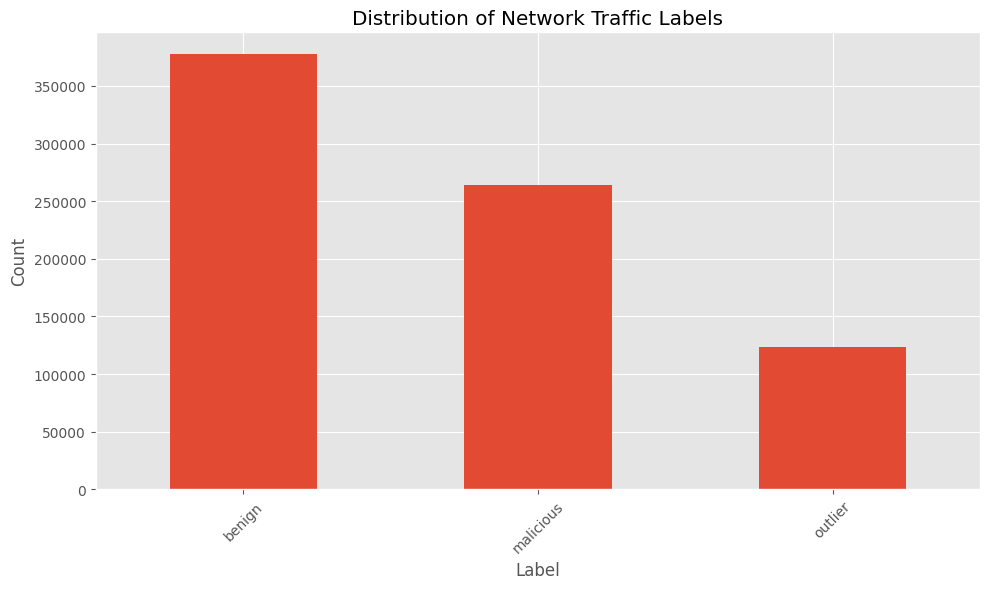


Summary statistics of numerical features:
            avg_ipt       bytes_in      bytes_out        dest_ip  \
count  7.653600e+05  765360.000000  765360.000000  765360.000000   
mean   3.496450e+06    1592.690275    3462.929138    2470.811163   
std    6.386029e+07    6512.809375    8789.176140   12904.890602   
min    0.000000e+00       0.000000       0.000000       3.000000   
25%    0.000000e+00       0.000000      51.000000     786.000000   
50%    0.000000e+00      12.000000     191.000000     786.000000   
75%    7.875000e+01     299.000000    2416.000000     786.000000   
max    4.294967e+09   65512.000000   65534.000000  327932.000000   

           dest_port        entropy   num_pkts_out    num_pkts_in  \
count  765360.000000  765360.000000  765360.000000  765360.000000   
mean    11256.602814       3.601672       8.320769       6.238910   
std     17023.798949       2.730748      26.132174      23.368682   
min        -1.000000       0.000000       0.000000       0.000000   

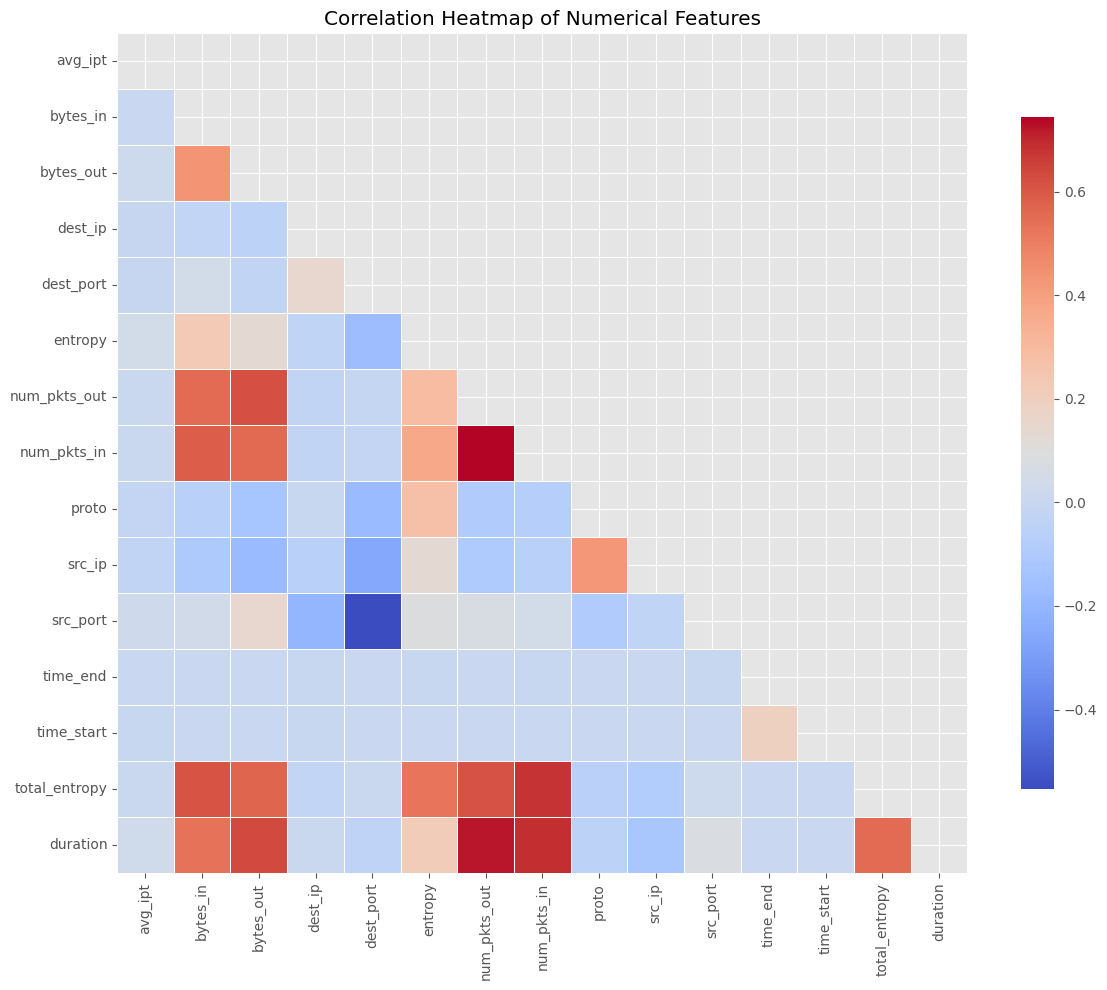


Training Random Forest model...
Model training completed in 79.46 seconds
Model saved to rf_intrusion_detection_model.joblib

Model Evaluation:
Accuracy: 0.9715
Precision: 0.9726
Recall: 0.9715
F1 Score: 0.9709

Classification Report:
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00     75858
   malicious       0.93      0.99      0.96     52377
     outlier       0.98      0.85      0.91     24837

    accuracy                           0.97    153072
   macro avg       0.97      0.95      0.96    153072
weighted avg       0.97      0.97      0.97    153072



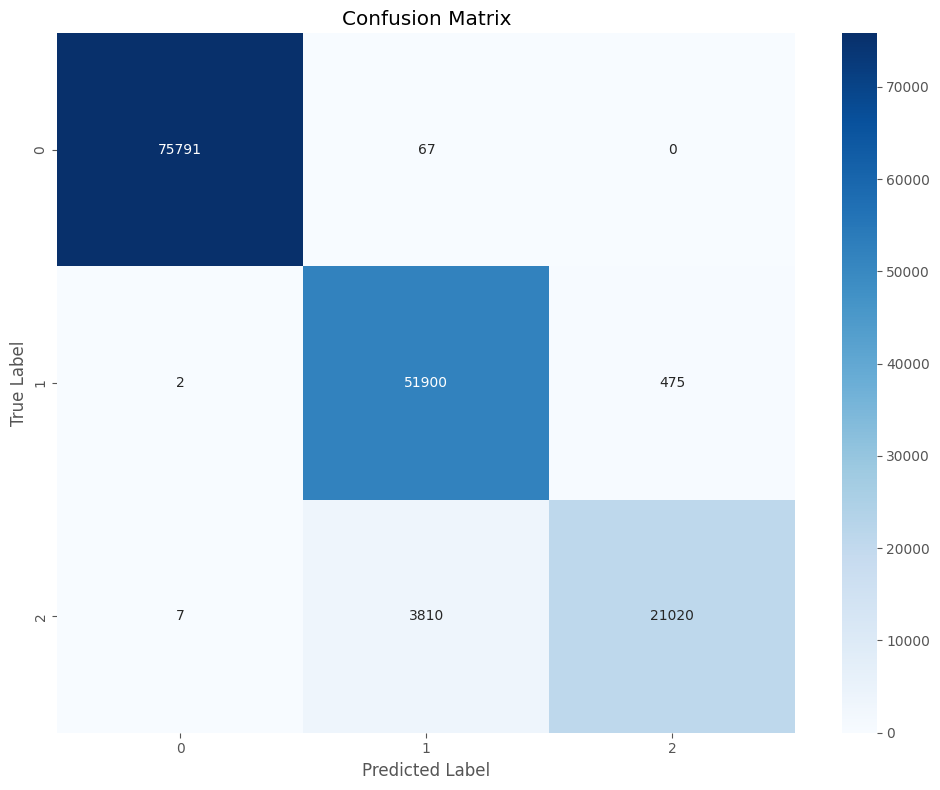

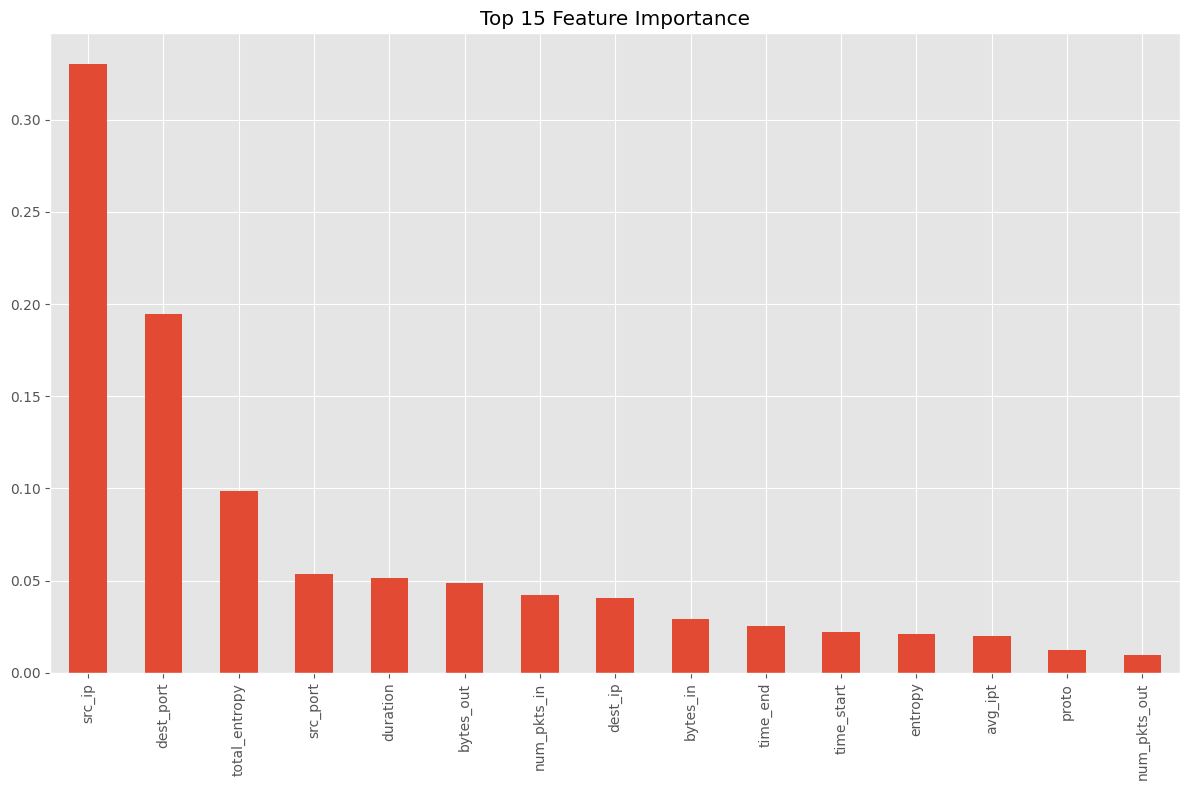

Error sending email: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d9443c01a7336-2278120a5b6sm104877425ad.252 - gsmtp')

Demo prediction on a sample of test data:
  True Label Predicted Label
0  malicious       malicious
1     benign          benign
2     benign          benign
3  malicious       malicious
4    outlier         outlier

Script completed successfully!


In [ ]:
import numpy as np
import pandas as pd
import time
import os
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.application import MIMEApplication
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import joblib

# Set plot style and size
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

# Define the path to your dataset
dataset_path = r"C:\Users\DC\OneDrive\Desktop\NITHISH\2020.06.19.csv"

print("Loading data from:", dataset_path)
try:
    # Load the dataset
    df = pd.read_csv(dataset_path)
    print(f"Successfully loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
except Exception as e:
    print(f"Error loading dataset: {e}")
    # If the original file path doesn't work, attempt to find the file in the current directory
    try:
        print("Attempting to find dataset in current directory...")
        files = os.listdir()
        csv_files = [f for f in files if f.endswith('.csv')]
        if csv_files:
            print(f"Found CSV files: {csv_files}")
            df = pd.read_csv(csv_files[0])
            print(f"Loaded alternative dataset: {csv_files[0]}")
        else:
            print("No CSV files found in current directory")
    except Exception as e2:
        print(f"Error searching for alternative dataset: {e2}")
        df = None

# If we have a dataframe, proceed with analysis
if df is not None:
    # Display the first few rows of the dataframe
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    
    # Basic information about the dataset
    print("\nDataset information:")
    print(df.info())
    
    # Check for missing values
    print("\nMissing values in each column:")
    print(df.isnull().sum())
    
    # Fill missing values
    if 'dest_port' in df.columns:
        df.dest_port = df.dest_port.fillna(-1).astype('int64')
    if 'src_port' in df.columns:
        df.src_port = df.src_port.fillna(-1).astype('int64')
    
    # Explore label distribution
    if 'label' in df.columns:
        print("\nLabel distribution:")
        label_counts = df.label.value_counts()
        print(label_counts)
        
        # Plot label distribution
        plt.figure(figsize=(10, 6))
        label_counts.plot(kind='bar')
        plt.title('Distribution of Network Traffic Labels')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('label_distribution.png')
        plt.show()
    
    # Explore numerical features
    print("\nSummary statistics of numerical features:")
    print(df.describe())
    
    # Visualize key features
    # Let's create a correlation heatmap for numerical features
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    if len(numeric_cols) > 2:  # Need at least a few columns for correlation
        plt.figure(figsize=(12, 10))
        correlation = df[numeric_cols].corr()
        mask = np.triu(correlation)
        sns.heatmap(correlation, annot=False, mask=mask, cmap='coolwarm', 
                   linewidths=0.5, cbar_kws={"shrink": .8})
        plt.title('Correlation Heatmap of Numerical Features')
        plt.tight_layout()
        plt.savefig('correlation_heatmap.png')
        plt.show()
    
    # Prepare the data for modeling
    if 'label' in df.columns:
        # Define features and target
        features = df.columns.drop('label')
        X = df[features]
        y = df['label']
        
        # For categorical features, we can use one-hot encoding
        categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
        if categorical_cols:
            X = pd.get_dummies(X, columns=categorical_cols)
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Scale the features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Save the scaler for future use
        joblib.dump(scaler, 'scaler.joblib')
        
        # Train the Random Forest model
        print("\nTraining Random Forest model...")
        start_time = time.time()
        
        # Create the model
        rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, 
                                         min_samples_split=10, random_state=42, n_jobs=-1)
        
        # Train the model
        rf_model.fit(X_train_scaled, y_train)
        
        # Calculate training time
        train_time = time.time() - start_time
        print(f"Model training completed in {train_time:.2f} seconds")
        
        # Save the model
        model_save_path = "rf_intrusion_detection_model.joblib"
        joblib.dump(rf_model, model_save_path)
        print(f"Model saved to {model_save_path}")
        
        # Make predictions on the test set
        y_pred = rf_model.predict(X_test_scaled)
        
        # Evaluate the model
        print("\nModel Evaluation:")
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        
        # If it's a multi-class classification problem
        if len(np.unique(y)) > 2:
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
        else:
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
        
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Display detailed classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()
        
        # Feature Importance
        if hasattr(rf_model, 'feature_importances_'):
            feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
            plt.figure(figsize=(12, 8))
            feature_importance.sort_values(ascending=False).head(15).plot(kind='bar')
            plt.title('Top 15 Feature Importance')
            plt.tight_layout()
            plt.savefig('feature_importance.png')
            plt.show()
        
        # Prepare results for email
        email_body = f"""
        Network Intrusion Detection Model Training Results
        
        Dataset: {dataset_path}
        Dataset Size: {df.shape[0]} rows x {df.shape[1]} columns
        
        Model: Random Forest
        Training Time: {train_time:.2f} seconds
        
        Model Performance:
        - Accuracy: {accuracy:.4f}
        - Precision: {precision:.4f}
        - Recall: {recall:.4f}
        - F1 Score: {f1:.4f}
        
        The model has been saved as '{model_save_path}'.
        Please find attached visualizations.
        """
        
        # Send email with results
        def send_email_notification(body, attachments=[]):
            try:
                # Load email configuration from app.py
                app_path = r"C:\Users\DC\OneDrive\Desktop\NITHISH\app.py"
                email_config = {}
                
                with open(app_path, 'r') as file:
                    content = file.read()
                    
                    # Extract email settings using simple parsing
                    import re
                    sender_match = re.search(r'sender_email\s*=\s*[\'"](.+?)[\'"]', content)
                    if sender_match:
                        email_config['sender_email'] = sender_match.group(1)
                    
                    password_match = re.search(r'email_password\s*=\s*[\'"](.+?)[\'"]', content)
                    if password_match:
                        email_config['email_password'] = password_match.group(1)
                    
                    receiver_match = re.search(r'receiver_email\s*=\s*[\'"](.+?)[\'"]', content)
                    if receiver_match:
                        email_config['receiver_email'] = receiver_match.group(1)
                
                # If we couldn't extract from app.py, use defaults
                if 'sender_email' not in email_config:
                    email_config['sender_email'] = "your_email@gmail.com"
                    email_config['email_password'] = "your_password"
                    email_config['receiver_email'] = "recipient_email@gmail.com"
                    print("Warning: Using default email settings. Please update with real values.")
                
                # Create email message
                msg = MIMEMultipart()
                msg['From'] = email_config['sender_email']
                msg['To'] = email_config['receiver_email']
                msg['Subject'] = "Network Intrusion Detection Model Results"
                
                # Attach body text
                msg.attach(MIMEText(body, 'plain'))
                
                # Attach files
                for file in attachments:
                    if os.path.exists(file):
                        with open(file, 'rb') as attachment:
                            part = MIMEApplication(attachment.read(), Name=os.path.basename(file))
                        part['Content-Disposition'] = f'attachment; filename="{os.path.basename(file)}"'
                        msg.attach(part)
                
                # Connect to server and send email
                server = smtplib.SMTP('smtp.gmail.com', 587)
                server.starttls()
                server.login(email_config['sender_email'], email_config['email_password'])
                server.send_message(msg)
                server.quit()
                
                print(f"Email notification sent to {email_config['receiver_email']}")
                
            except Exception as e:
                print(f"Error sending email: {e}")
        
        # Send the email with attachments
        attachments = [
            'label_distribution.png',
            'correlation_heatmap.png',
            'confusion_matrix.png',
            'feature_importance.png',
            model_save_path
        ]
        
        # Ask if user wants to send email
        send_email = input("\nDo you want to send an email notification with the results? (y/n): ")
        if send_email.lower() == 'y':
            send_email_notification(email_body, attachments)
    else:
        print("Error: The dataset does not contain a 'label' column. Cannot proceed with model training.")
else:
    print("Error: Could not load any dataset. Please check the file path and try again.")

# Additional functionality: Model prediction function
def predict_intrusion(input_data, model_path="rf_intrusion_detection_model.joblib", scaler_path="scaler.joblib"):
    """
    Function to make predictions using the trained model
    
    Parameters:
    -----------
    input_data : pandas DataFrame
        New data for prediction
    model_path : str
        Path to the saved model
    scaler_path : str
        Path to the saved scaler
    
    Returns:
    --------
    predictions : array
        Predicted labels
    """
    try:
        # Load the model
        model = joblib.load(model_path)
        
        # Load the scaler
        scaler = joblib.load(scaler_path)
        
        # Prepare the data
        # For categorical features, use one-hot encoding
        categorical_cols = input_data.select_dtypes(include=['object']).columns.tolist()
        if categorical_cols:
            input_data = pd.get_dummies(input_data, columns=categorical_cols)
        
        # Scale the data
        input_data_scaled = scaler.transform(input_data)
        
        # Make predictions
        predictions = model.predict(input_data_scaled)
        
        return predictions
    
    except Exception as e:
        print(f"Error making predictions: {e}")
        return None

# Demo prediction if we have data
if 'df' in locals() and df is not None and 'label' in df.columns:
    print("\nDemo prediction on a sample of test data:")
    
    # Take a small sample of the test set
    sample_size = min(5, X_test.shape[0])
    sample_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)
    
    sample_data = X_test.iloc[sample_indices]
    true_labels = y_test.iloc[sample_indices]
    
    # Make predictions
    predictions = predict_intrusion(sample_data)
    
    if predictions is not None:
        # Display results
        results = pd.DataFrame({
            'True Label': true_labels.values,
            'Predicted Label': predictions
        })
        print(results)
    else:
        print("Prediction function failed.")

print("\nScript completed successfully!")